# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Hyperparameter

In [2]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'SGD/IDR']

SEQ_LEN = 21 # 6, 11, 21
SPLIT = 0.90 # 0.80, 0.90
LSTM_Layer = 3 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

## Data Overview
From Google Finance

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[2]}'
df = pd.read_csv(url)

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1959 non-null   datetime64[ns]
 1   Close   1959 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.7 KB


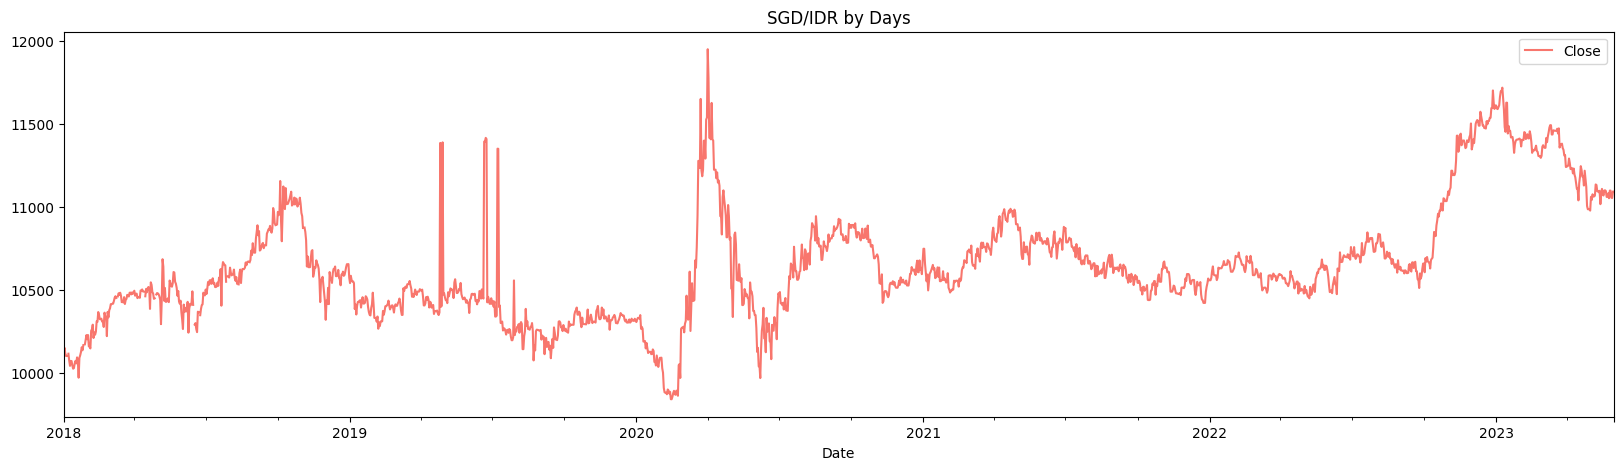

In [4]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title=f'{SHEET_NAME[2]} by Days')

## Data preprocessing

### Normalize

In [5]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1959, 1)

In [6]:
scaled_close

array([[0.13503666],
       [0.14700219],
       [0.13068802],
       ...,
       [0.57488343],
       [0.59368865],
       [0.59277804]])

### Making sequences

In [7]:
def to_sequences(data, seq_len):
    """
    Converts a list of data into a sequence of equal length.

    Args:
        data: A list of numerical values.
        seq_len: An integer indicating the length of each sequence.

    Returns:
        A numpy array of shape (len(data) - seq_len, seq_len) containing the sequences.
    """
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    """
    Preprocesses the raw data for training and testing.

    Args:
        data_raw: A list of numerical values.
        seq_len: An integer indicating the length of each sequence.
        train_split: A float between 0 and 1 indicating the fraction of data to use for training.

    Returns:
        A tuple of four numpy arrays: (X_train, y_train, X_test, y_test).
        X_train and X_test are the input sequences for training and testing, respectively.
        y_train and y_test are the output values for training and testing, respectively.
    """
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

In [8]:
print("----------- Train Data Shape -----------")
print(X_train.shape)
print(y_train.shape)
print("----------- Test Data Shape -----------")
print(X_test.shape)
print(y_test.shape)

----------- Train Data Shape -----------
(1744, 20, 1)
(1744, 1)
----------- Test Data Shape -----------
(194, 20, 1)
(194, 1)


## Modeling

### Building LSTM model

In [11]:
tf.keras.backend.clear_session()
model = Sequential()

for i, units in enumerate([128, 64, 32][:LSTM_Layer]):
    model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


### Training

In [248]:
BATCH_SIZE = 32
EPOCH = 50
VAL_SPLIT = 0.1

model.compile(
    loss='mse',
    metrics=['mae', RootMeanSquaredError()],
    optimizer='adam',
)
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_split=VAL_SPLIT)

Epoch 1/50
50/50 [==============================] - 9s 116ms/step - loss: 0.0110 - mae: 0.0682 - root_mean_squared_error: 0.1047 - val_loss: 0.0070 - val_mae: 0.0654 - val_root_mean_squared_error: 0.0838
Epoch 2/50
50/50 [==============================] - 5s 97ms/step - loss: 0.0041 - mae: 0.0389 - root_mean_squared_error: 0.0637 - val_loss: 0.0029 - val_mae: 0.0395 - val_root_mean_squared_error: 0.0539
Epoch 3/50
50/50 [==============================] - 5s 96ms/step - loss: 0.0037 - mae: 0.0369 - root_mean_squared_error: 0.0611 - val_loss: 0.0022 - val_mae: 0.0345 - val_root_mean_squared_error: 0.0473
Epoch 4/50
50/50 [==============================] - 5s 103ms/step - loss: 0.0033 - mae: 0.0346 - root_mean_squared_error: 0.0577 - val_loss: 0.0047 - val_mae: 0.0569 - val_root_mean_squared_error: 0.0682
Epoch 5/50
50/50 [==============================] - 5s 101ms/step - loss: 0.0032 - mae: 0.0342 - root_mean_squared_error: 0.0569 - val_loss: 0.0011 - val_mae: 0.0264 - val_root_mean_squa

### Model Evaluation

In [249]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 27ms/step - loss: 0.0023 - mae: 0.0434 - root_mean_squared_error: 0.0475


[0.00225828867405653, 0.043430209159851074, 0.047521453350782394]

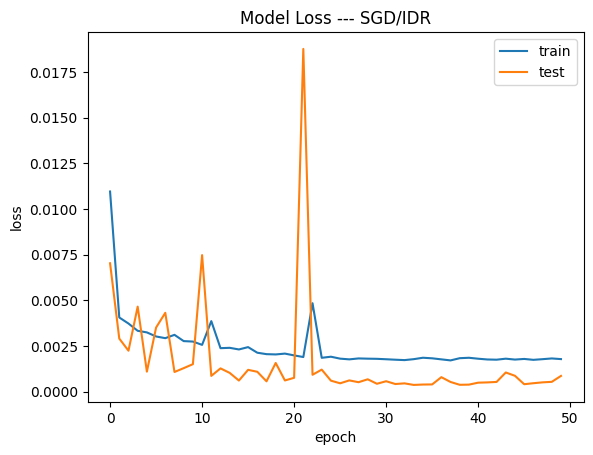

In [250]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss --- {SHEET_NAME[2]}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[2][:3]} Model Loss_LSTM_{LSTM_Layer}_Split_{SPLIT}_Window_{WINDOW_SIZE}.png')
plt.show()

## Prediction

In [251]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

7/7 [==============================] - 1s 20ms/step


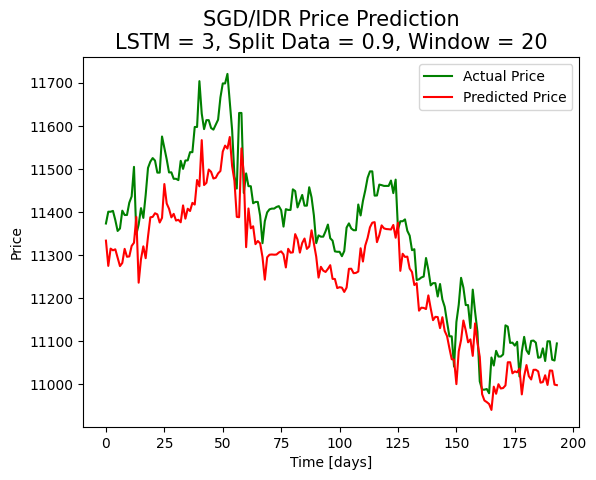

In [252]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title(f'{SHEET_NAME[2]} Price Prediction\nLSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}', fontsize=15)
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.savefig(f'D:/Collage/Courses/Skripsi/Gambar/Hasil Skenario/{SHEET_NAME[2][:3]} Price Prediction_LSTM_{LSTM_Layer}_Split_{SPLIT}_Window_{WINDOW_SIZE}.png')
plt.show()

In [253]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Mean Squared Error for prediction :", mse)
    print("Root Mean Squared Error for prediction :", rmse)
    return mae, mse, rmse

print(f"LSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}")
print("\n----------------- Normalized Error -----------------")
mae, mse, rmse = matrices(y_test, y_hat)
print("\n----------------- Actual Error -----------------")
mae_inverse, mse_inverse, rmse_inverse = matrices(y_test_inverse, y_hat_inverse)

LSTM = 3, Split Data = 0.9, Window = 20

----------------- Normalized Error -----------------
Mean Absolute Error for prediction : 0.0434302170922635
Mean Squared Error for prediction : 0.0022582890454220313
Root Mean Squared Error for prediction : 0.04752145878886749

----------------- Actual Error -----------------
Mean Absolute Error for prediction : 91.57070030605658
Mean Squared Error for prediction : 10039.427959891842
Root Mean Squared Error for prediction : 100.19694586109819


In [254]:
error_result = pd.DataFrame([[SHEET_NAME[2], LSTM_Layer, WINDOW_SIZE, SPLIT, np.nan, mae_inverse, mse_inverse, rmse_inverse]],
                            columns=['Type', 'LSTM Layer', 'Window', 'Split', 'CV (Fold)', 'MAE', 'MSE', 'RMSE'])
hasil = pd.read_excel('Hasil.xlsx')
final = pd.concat([hasil, error_result], ignore_index=True)
final.to_excel('Hasil.xlsx', index=False)